In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load dataset
df = pd.read_csv('../checked-data.csv')
df_ranks = pd.read_csv("../ranked_questions_by_category.csv", index_col=[0, 1, 2])

In [5]:
# Mapping for negative marking based on rank
penalty_map = {
    5: 1.0,
    4: 0.8,
    3: 0.6,
    2: 0.4,
    1: 0.2  # Least common wrong answer
}

In [6]:
def calculate_marks(row):
    image_parts = row['image'].split('_')
    prefix1 = image_parts[0]
    prefix2 = image_parts[1]
    set_id = int(row['set'])

    # Retrieve corresponding ranks
    ranks = df_ranks.loc[(prefix1, prefix2, set_id)]
    
    marks = 0
    for q in ['q1', 'q2', 'q3', 'q4', 'q5']:
        if row[q] == True:
            marks += 1
        else:
            rank = ranks[q]
            marks -= penalty_map.get(rank, 0)  # Default to 0 if rank not in map
    return marks

# Compute and store the scores
df['total_score'] = df.apply(calculate_marks, axis=1)

# Display a sample to verify
print(df[['image', 'total_score']].head())

                      image  total_score
0     er_posttest_lab_1.png          3.8
1  er_posttest_lab_1004.png          0.6
2  er_posttest_lab_1015.png          3.6
3  er_posttest_lab_1017.png          2.4
4  er_posttest_lab_1036.png          5.0


In [7]:
# Step 1: Split the dataset into "lab" and "non-lab" groups
lab_data = df[df['image'].str.contains('lab', case=False, na=False)].copy()
# print(lab_data)
classroom_data = df[~df['image'].str.contains('lab', case=False, na=False)].copy()
# print(classroom_data)

In [8]:
def calculate_delta(group):
    pretest_data = group[group['image'].str.contains('pretest', case=False, na=False)]
    posttest_data = group[group['image'].str.contains('posttest', case=False, na=False)]
    
    deltas = []

    for _, pretest_row in pretest_data.iterrows():
        filename_parts = pretest_row['image'].replace('.png', '').split('_')

        answer_type, _, group_type, roll = filename_parts
        match_key = f"{answer_type}_posttest_{group_type}_{roll}.png"

        matched_row = posttest_data[posttest_data['image'] == match_key]

        if not matched_row.empty:
            pre_score = pretest_row['total_score']
            post_score = matched_row.iloc[0]['total_score']
            delta = post_score - pre_score
            deltas.append((pretest_row['image'], delta))

            print(f"    Match Found:")
            print(f"    Pretest Image: {pretest_row['image']}, Score: {pre_score}")
            print(f"    Posttest Image: {match_key}, Score: {post_score}")
            print(f"    → Delta: {delta}\n")
        else:
            print(f"    No match found for: {pretest_row['image']} → {match_key}\n")
    
    return deltas


In [9]:
# Step 2: Calculate deltas for lab group
lab_deltas = calculate_delta(lab_data)

# Print the results
# print("Lab Deltas (Pretest to Posttest):")
# for image, delta in lab_deltas:
#     print(f"{image}: {delta}")

    Match Found:
    Pretest Image: er_pretest_lab_1.png, Score: 0.4
    Posttest Image: er_posttest_lab_1.png, Score: 3.8
    → Delta: 3.4

    Match Found:
    Pretest Image: er_pretest_lab_1004.png, Score: 2.4
    Posttest Image: er_posttest_lab_1004.png, Score: 0.6
    → Delta: -1.7999999999999998

    Match Found:
    Pretest Image: er_pretest_lab_1015.png, Score: 0.0
    Posttest Image: er_posttest_lab_1015.png, Score: 3.6
    → Delta: 3.6

    Match Found:
    Pretest Image: er_pretest_lab_1017.png, Score: 3.8
    Posttest Image: er_posttest_lab_1017.png, Score: 2.4
    → Delta: -1.4

    Match Found:
    Pretest Image: er_pretest_lab_1036.png, Score: 2.2
    Posttest Image: er_posttest_lab_1036.png, Score: 5.0
    → Delta: 2.8

    Match Found:
    Pretest Image: er_pretest_lab_1043.png, Score: -1.4
    Posttest Image: er_posttest_lab_1043.png, Score: 0.4
    → Delta: 1.7999999999999998

    Match Found:
    Pretest Image: er_pretest_lab_1047.png, Score: 1.2
    Posttest Image:

In [10]:

# Step 3: Calculate deltas for non-lab group
classroom_deltas = calculate_delta(classroom_data)

# print("\nClassRoom Deltas (Pretest to Posttest):")
# for image, delta in classroom_deltas:
#     print(f"{image}: {delta}")

    Match Found:
    Pretest Image: er_pretest_watrin_1001.png, Score: 2.4
    Posttest Image: er_posttest_watrin_1001.png, Score: 2.0
    → Delta: -0.3999999999999999

    Match Found:
    Pretest Image: er_pretest_watrin_1003.png, Score: 0.7999999999999998
    Posttest Image: er_posttest_watrin_1003.png, Score: -1.2000000000000002
    → Delta: -2.0

    Match Found:
    Pretest Image: er_pretest_watrin_1006.png, Score: -3.0
    Posttest Image: er_posttest_watrin_1006.png, Score: -1.2
    → Delta: 1.8

    Match Found:
    Pretest Image: er_pretest_watrin_1007.png, Score: 2.1999999999999997
    Posttest Image: er_posttest_watrin_1007.png, Score: 3.8
    → Delta: 1.6

    Match Found:
    Pretest Image: er_pretest_watrin_1008.png, Score: 3.8
    Posttest Image: er_posttest_watrin_1008.png, Score: 3.8
    → Delta: 0.0

    Match Found:
    Pretest Image: er_pretest_watrin_1009.png, Score: 0.4000000000000001
    Posttest Image: er_posttest_watrin_1009.png, Score: 2.4
    → Delta: 1.99999

In [11]:
# function to calculate the summary statistics
def summarize_scores(group, group_name):
    pretest_scores = group[group['image'].str.contains('pretest', case=False)]['total_score']
    posttest_scores = group[group['image'].str.contains('posttest', case=False)]['total_score']

    print(f"\n===== {group_name.upper()} GROUP SUMMARY =====")

    print("\n--- Pretest Summary ---")
    print(f"Mean: {pretest_scores.mean():.2f}")
    print(f"Median: {pretest_scores.median():.2f}")
    print(f"Standard Deviation: {pretest_scores.std():.2f}")
    print(f"Min: {pretest_scores.min()}")
    print(f"Max: {pretest_scores.max()}")

    print("\n--- Posttest Summary ---")
    print(f"Mean: {posttest_scores.mean():.2f}")
    print(f"Median: {posttest_scores.median():.2f}")
    print(f"Standard Deviation: {posttest_scores.std():.2f}")
    print(f"Min: {posttest_scores.min()}")
    print(f"Max: {posttest_scores.max()}")

# functions to summarize the statistics from delta:)
def summarize_deltas(deltas, group_name):
    delta_values = [d[1] for d in deltas]

    print(f"\n===== Delta Summary for {group_name.upper()} Group =====")
    print(f"Mean Delta: {np.mean(delta_values):.2f}")
    print(f"Median Delta: {np.median(delta_values):.2f}")
    print(f"Standard Deviation: {np.std(delta_values):.2f}")
    print(f"Min Delta: {np.min(delta_values)}")
    print(f"Max Delta: {np.max(delta_values)}")

    print(f"\nDelta Counts:")
    print(f"  Positive change: {sum(1 for d in delta_values if d > 0)}")
    print(f"  Negative change: {sum(1 for d in delta_values if d < 0)}")
    print(f"  No change: {sum(1 for d in delta_values if d == 0)}")


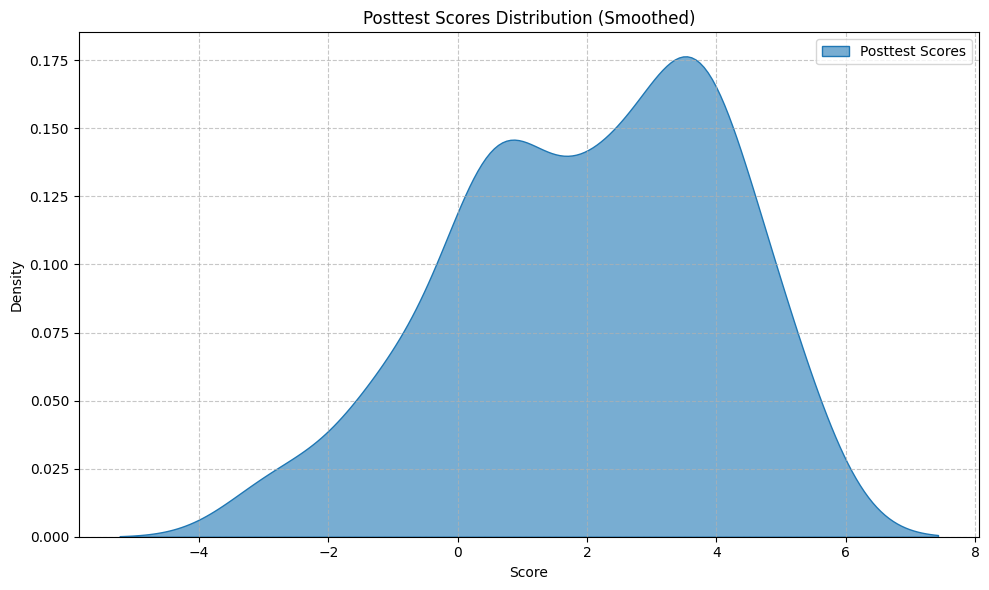

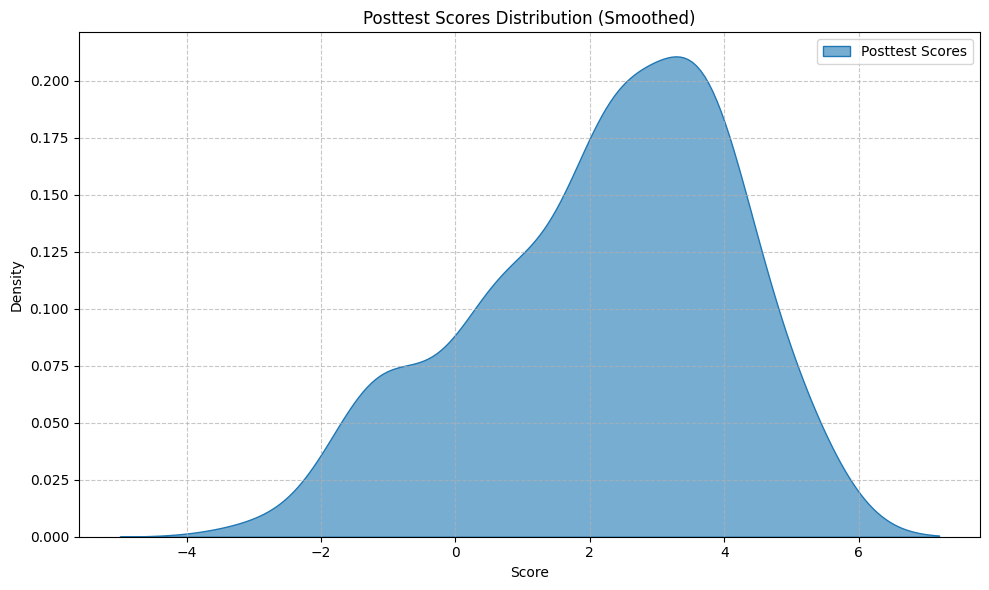

In [12]:
# Create a line graph for posttest scores
plt.figure(figsize=(10, 6))
posttest_scores = lab_data[lab_data['image'].str.contains('posttest', case=False)]['total_score']
sns.kdeplot(posttest_scores, fill=True, alpha=0.6, label='Posttest Scores')
plt.title("Posttest Scores Distribution (Smoothed)")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
posttest_scores = classroom_data[classroom_data['image'].str.contains('posttest', case=False)]['total_score']
sns.kdeplot(posttest_scores, fill=True, alpha=0.6, label='Posttest Scores')
plt.title("Posttest Scores Distribution (Smoothed)")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
summarize_deltas(lab_deltas, "Lab")
summarize_deltas(classroom_deltas, "Watrin")


===== Delta Summary for LAB Group =====
Mean Delta: 1.34
Median Delta: 1.40
Standard Deviation: 2.63
Min Delta: -4.4
Max Delta: 8.0

Delta Counts:
  Positive change: 73
  Negative change: 29
  No change: 4

===== Delta Summary for WATRIN Group =====
Mean Delta: 1.43
Median Delta: 1.60
Standard Deviation: 2.44
Min Delta: -3.3999999999999995
Max Delta: 7.6

Delta Counts:
  Positive change: 71
  Negative change: 30
  No change: 3


In [14]:
def visualize_group_scores(group, deltas, group_name):
    pretest_scores = group[group['image'].str.contains('pretest', case=False)]['total_score']
    posttest_scores = group[group['image'].str.contains('posttest', case=False)]['total_score']
    delta_values = [d[1] for d in deltas]

    # Set visual style
    sns.set_theme(style='whitegrid')

    # Plot histograms for Pretest and Posttest
    # plt.figure(figsize=(12, 5))
    plt.hist(pretest_scores, bins=10, alpha=0.6, label='Pretest', color='skyblue', edgecolor='black')
    plt.hist(posttest_scores, bins=10, alpha=0.6, label='Posttest', color='salmon', edgecolor='black')
    plt.title(f"{group_name} Group: Pretest vs Posttest Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Boxplot for Pretest and Posttest, not very insightful in this case:)
    # plt.figure(figsize=(8, 5))
    # sns.boxplot(data=[pretest_scores, posttest_scores], palette=["skyblue", "salmon"])
    # plt.xticks([0, 1], ['Pretest', 'Posttest'])
    # plt.title(f"{group_name} Group: Score Comparison (Boxplot)")
    # plt.ylabel("Score")
    # plt.tight_layout()
    # plt.show()

    # Histogram for Delta values
    # plt.figure(figsize=(10, 5))
    sns.histplot(delta_values, bins=10, kde=True, color='purple', edgecolor='black')
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"{group_name} Group: Delta (Posttest - Pretest) Distribution")
    plt.xlabel("Delta")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

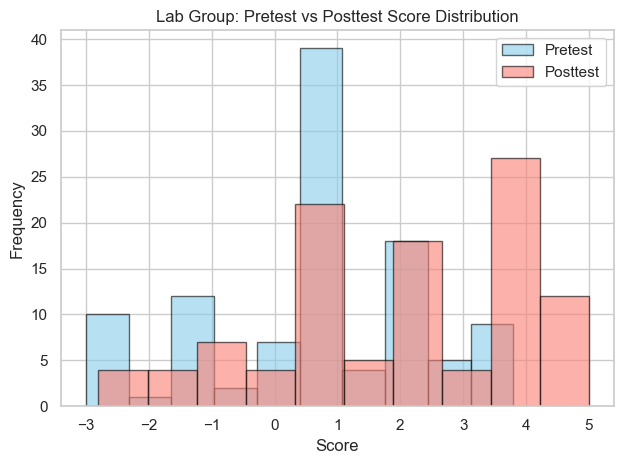

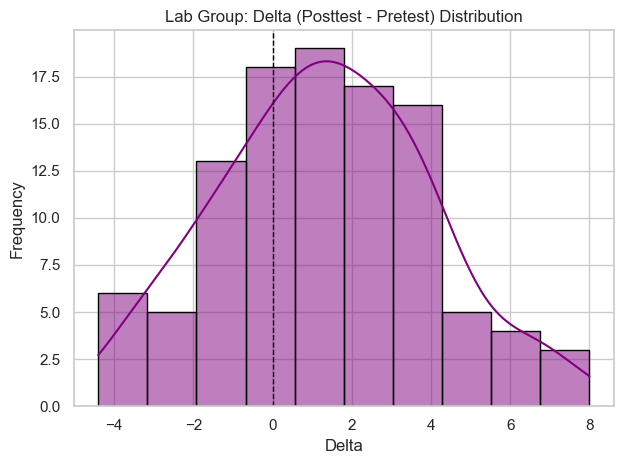

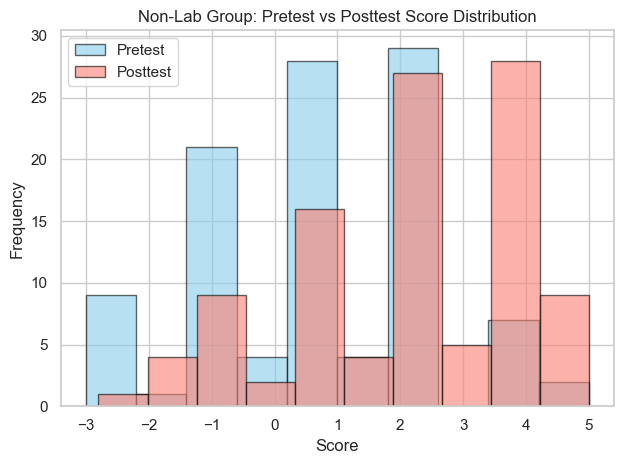

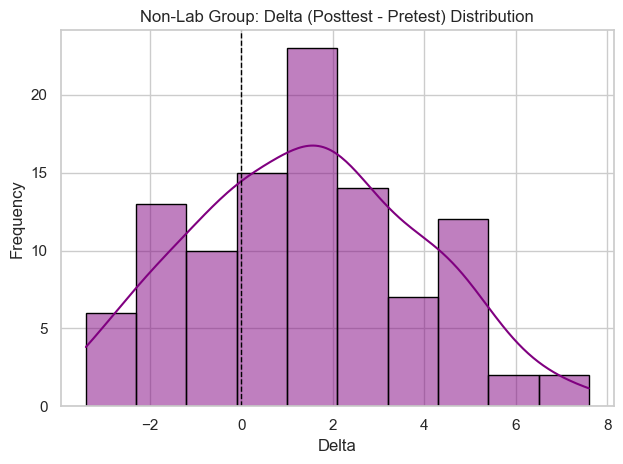

In [15]:
visualize_group_scores(lab_data, lab_deltas, "Lab")
visualize_group_scores(classroom_data, classroom_deltas, "Non-Lab")

In [16]:
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
import numpy as np

# Extract delta values from lab_deltas and non_lab_deltas
lab_delta_values = [delta[1] for delta in lab_deltas]
non_lab_delta_values = [delta[1] for delta in classroom_deltas]

# Step 1: Check for normality
print("Running Shapiro-Wilk test for normality...")

shapiro_lab = shapiro(lab_delta_values)
shapiro_non_lab = shapiro(non_lab_delta_values)

print(f"\nLab Group:     W = {shapiro_lab.statistic:.4f}, p-value = {shapiro_lab.pvalue:.4f}")
print(f"Non-Lab Group: W = {shapiro_non_lab.statistic:.4f}, p-value = {shapiro_non_lab.pvalue:.4f}")

is_lab_normal = shapiro_lab.pvalue > 0.05
is_non_lab_normal = shapiro_non_lab.pvalue > 0.05

print("\nAt least one group is not normally distributed. Using Mann-Whitney U test (non-parametric)...")
    
mw_result = mannwhitneyu(lab_delta_values, non_lab_delta_values, alternative='two-sided')
print(f"Mann-Whitney U Test: U = {mw_result.statistic:.4f}, p-value = {mw_result.pvalue:.4f}")

if mw_result.pvalue < 0.05:
    print("→ Inference: Statistically significant difference between the two groups (based on ranks).")
else:
    print("→ Inference: No statistically significant difference detected.")

# Effect size: Rank-biserial correlation
n1 = len(lab_delta_values)
n2 = len(non_lab_delta_values)
u = mw_result.statistic
rbc = 1 - (2 * u) / (n1 * n2)
print(f"Rank-Biserial Correlation (Effect Size): {rbc:.4f}")

if abs(rbc) < 0.1:
    print("→ Interpretation: Very small or negligible effect.")
elif abs(rbc) < 0.3:
    print("→ Interpretation: Small effect size.")
elif abs(rbc) < 0.5:
    print("→ Interpretation: Medium effect size.")
else:
    print("→ Interpretation: Large effect size.")

Running Shapiro-Wilk test for normality...

Lab Group:     W = 0.9889, p-value = 0.5322
Non-Lab Group: W = 0.9854, p-value = 0.3120

At least one group is not normally distributed. Using Mann-Whitney U test (non-parametric)...
Mann-Whitney U Test: U = 5376.0000, p-value = 0.7582
→ Inference: No statistically significant difference detected.
Rank-Biserial Correlation (Effect Size): 0.0247
→ Interpretation: Very small or negligible effect.
